In [1]:
import numpy as np
from drone_sac import AgentParallel3layers, BufferParallel
from drone_gym import DroneGym3
from tqdm.notebook import tqdm
import torch as T
import matplotlib.pyplot as plt

In [2]:
env = DroneGym3.make()
agent = AgentParallel3layers(
    input_dims=env.obs_max.shape, 
    n_actions=2, 
    action_space_high=env.action_space.high,
    device_name='cpu')
buffer = BufferParallel(agent)

agent_md = AgentParallel3layers(
    input_dims=env.obs_missile_max.shape, 
    n_actions=2, 
    action_space_high=env.action_space.high,
    device_name='cpu')
buffer_md = BufferParallel(agent_md)

import pickle
with open('agent_dict3.bin', 'rb') as f:
    agent_dict = pickle.load(f)
agent.from_dict(agent_dict)

import pickle
with open('agent_dict3_md.bin', 'rb') as f:
    agent_dict_md = pickle.load(f)
agent_md.from_dict(agent_dict_md)

In [9]:
env.record_history = True
env.antiflip = False
n = 0

observation, observation_md = env.reset()
done = False
done_md = False
while (not done) and (not done_md):
    action = agent.choose_action_determ(observation)
    action_md = agent_md.choose_action_determ(observation_md)

    (observation_, reward, done, info), (observation_md_, reward_md, done_md, info_md) = env.step(action, action_md)

    buffer.store_transition(observation, action, reward, observation_, done)
    buffer_md.store_transition(observation_md, action_md, reward_md, observation_md_, done_md)

    observation = observation_
    observation_md = observation_md_
    n+=1

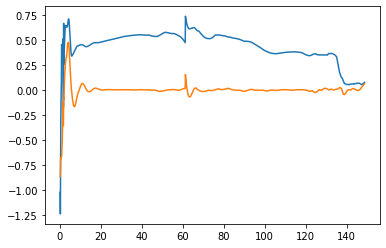

In [10]:
from ipywidgets import interact, interactive, fixed
import ipywidgets
import matplotlib.pyplot as plt
gym = env

xs = []
ys = []
f1s = []
f2s = []
rewards = []
rewards_md = []
ts = []
dts = []
scores = [0]
vels = []
xsm = []
ysm = []
omegas = []
for d in gym.history:
    gym.set_state(d['state'])
    xs.append(gym.drone.pos.x)
    ys.append(gym.drone.pos.y)
    omegas.append(gym.drone.omega)
    f1, f2 = d['actions']
    f1s.append(f1)
    f2s.append(f2)
    ts.append(gym.time_curr)
    rewards.append(d['reward'])
    rewards_md.append(d['reward_md'])
    dts.append(d['delta_t1'])
    scores.append(scores[-1]+d['reward'])
    vels.append(gym.drone.vel.len())
    xsm.append(gym.missiledrone.pos.x)
    ysm.append(gym.missiledrone.pos.y)
scores = scores[1:]
i1=0
i2=-1
# plt.plot(ts[i1:i2], rewards[i1:i2])
plt.plot(ts[i1:i2], f1s[i1:i2])
plt.plot(ts[i1:i2], f2s[i1:i2])
# plt.plot(ts[i1:i2], dts[i1:i2])

In [11]:
@interact(i=ipywidgets.IntSlider(min=0,max=len(gym.history)-1,step=1, value=0),
         ideal_traj=ipywidgets.Checkbox(value=True, description ='(зел) оценка траетктории до цели'),
         drone_traject=ipywidgets.Checkbox(value=True, description ='(синяя) траектория дрона '),
         missile_traject=ipywidgets.Checkbox(value=True, description ='(красная) траектория ракеты '))
def plot_history(i,ideal_traj,drone_traject, missile_traject):
    d = gym.history[i]
    i1=0#max(0,i-30)
    i2=i+1
    gym.set_state(d['state'])
    fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(14,7))
    gym.plot(ax, drone_mashtb=150, vec_mashtb=10, actions=d['actions'],
             drone_mashtb_md=150, vec_mashtb_md=10, actions_md=d['actions_missiledrone'],
             ideal_traj=ideal_traj, missile_d=True, ideal_traj_md=True)
    if drone_traject:
        ax.plot(xs[i1:i],ys[i1:i],ls=':',c='blue')
    if missile_traject:
        ax.plot(xsm[i1:i],ysm[i1:i],ls=':',c='red')
    ax.set_aspect('equal', adjustable='box')
    
    
#     ax2.plot(ts[i1:i2], f1s[i1:i2])
#     ax2.plot(ts[i1:i2], f2s[i1:i2])
    ax2.grid()
#     ax2.plot(ts[:i2], vels[:i2])
    ax2.plot(ts[:i2], omegas[:i2])
    
    ax3.plot(ts[:i2], rewards[:i2])
    ax3.plot(ts[:i2], rewards_md[:i2])
    ax3.grid()
    ax.grid()
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=1488), Checkbox(value=True, description='(зел) о…

In [12]:
info

{'result_md': 'success', 'final_reward_md': 100, 'info_md': 'missiledrone win'}

In [1]:
from drone_gym import Drone2d

<frozen importlib._bootstrap>:219: RuntimeWarning: easyvec.vectors.Vec3 size changed, may indicate binary incompatibility. Expected 40 from C header, got 48 from PyObject


In [2]:
drone = Drone2d.get_DJI()

In [3]:
drone.to_dict()

{'t': 0.0,
 'pos': Vec2(0.0, 0.0),
 'vel': Vec2(0.0, 0.0),
 'alpha': 0.0,
 'omega': 0.0}

In [4]:
drone.from_dict(
{'t': 0.0,
 'pos': (0.0, 0.0),
 'vel': (0.01, 0.0),
 'alpha': 0.0,
 'omega': 0.0}
)

In [6]:
drone.get_delta_t_minimum_moving_trg((5,5), (1,0),(2,0),10,3,1e-5)

Norm t3=0.6422404915409151
Norm t1=2.720402936861196 t3=4.401611951841415
Norm t1=4.2943173854175445 t3=4.294323798720978


4.294323798720978